In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../../../Datasets/MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../../Datasets/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../../Datasets/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../../Datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../../Datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
train_data = mnist.train.images
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
train_labels_names = np.argmax(train_labels, axis=1)
test_data = mnist.test.images
test_labels = np.asarray(mnist.test.labels, dtype=np.int32)
test_labels_names = np.argmax(test_labels, axis=1)

print("train_data: ", train_data.shape)
print("train_labels: ", train_labels.shape)
print("test_data: ", test_data.shape)
print("test_labels: ", test_labels.shape)

train_data:  (55000, 784)
train_labels:  (55000, 10)
test_data:  (10000, 784)
test_labels:  (10000, 10)


In [4]:
num_of_domains = 2
num_of_features = [784, 784]
domain_names = ["domain_0", "domain_1"]

# num_of_domains = 3
# num_of_features = [784, 784, 784]
# domain_names = ["domain_0", "domain_1", "domain_2"]

# num_of_domains = 3
# num_of_features = [10, 20, 30]
# domain_names = ["domain_0", "domain_1", "domain_2"]

In [5]:
# last hidden layer's units will be concatenated and use as laten code
HIDDEN_LAYER_UNITS = [512, 384, 256] # [500, 250, 100]
ACTIVATION_FUNCTION = tf.nn.elu
#CODE_VECTOR = 10
LEARNING_RATE = 0.0001
TRAINING_EPOCHS = 1000
BETA = 5 # Bad: 1, 5, 20; Good: 0.01, 0.1

In [6]:
def encoder(X, domain_name):
    for i in range(1, len(HIDDEN_LAYER_UNITS)+1):
        if i == 1:
            net = tf.layers.dense(inputs=X, units=HIDDEN_LAYER_UNITS[i-1], activation=ACTIVATION_FUNCTION, name="Encoder_"+domain_name+"_layer_"+str(i))
            #print(net)
        else:
            net = tf.layers.dense(inputs=net, units=HIDDEN_LAYER_UNITS[i-1], activation=ACTIVATION_FUNCTION, name="Encoder_"+domain_name+"_layer_"+str(i))
            #print(net)
    return net

def latent_code(X):
    _, encoder_len = X.get_shape()
    z_mu = tf.layers.dense(inputs=X, units=encoder_len, activation=None, name='z_mu')
    z_log_sigma_sq = tf.layers.dense(inputs=X, units=encoder_len, activation=None, name='z_log_sigma_sq')
    eps = tf.random_normal(shape=tf.shape(z_log_sigma_sq), mean=0, stddev=1, dtype=tf.float32)
    z = z_mu + tf.sqrt(tf.exp(z_log_sigma_sq)) * eps # The reparameterization trick
    
    return z, z_mu, z_log_sigma_sq

def decoder(net, domain_size, domain_name):
    for i in range(len(HIDDEN_LAYER_UNITS), 0, -1):
        net = tf.layers.dense(inputs=net, units=HIDDEN_LAYER_UNITS[i-1], activation=ACTIVATION_FUNCTION, name="Decoder_"+domain_name+"_layer_"+str(i))
        #print(net)
    net = tf.layers.dense(inputs=net, units=domain_size, activation=tf.sigmoid, name="Decoder_Final_"+domain_name) # For MNIST, pixels are between 0 & 1
    #print(net)
    return net

def loss(true_output, prediction, latent_loss):
    
    # Reconstruction cost
    recon_loss = -tf.reduce_sum(true_output * tf.log(1e-10+prediction) + (1-true_output) * tf.log(1e-10+1-prediction), axis=1)
    cost = tf.reduce_mean(recon_loss)
    
    cost = tf.reduce_mean(cost + latent_loss)
    
    return cost

In [7]:
placeholder = {"input":[], "output":[], "prediction": []}

for a_domain in range(num_of_domains):
    placeholder["input"].append(tf.placeholder("float", [None, num_of_features[a_domain]], name='input_'+str(a_domain)))
    placeholder["output"].append(tf.placeholder("float", [None, num_of_features[a_domain]], name='output_'+str(a_domain)))

encoder_outputs = encoder(placeholder["input"][0], domain_names[0])
for a_domain in range(1, num_of_domains):
    a_encoder_output = encoder(placeholder["input"][a_domain], domain_names[a_domain])
    encoder_outputs= tf.concat([encoder_outputs, a_encoder_output], axis=1, name='encoder_outputs')
print("encoder_outputs: ", encoder_outputs)

code_prediction, z_mu, z_log_sigma_sq = latent_code(encoder_outputs)
print("code_prediction: ", code_prediction)

for a_domain in range(num_of_domains):
    a_decoder_output = decoder(code_prediction, num_of_features[a_domain], domain_names[a_domain])
    placeholder["prediction"].append(a_decoder_output)
print("prediction: ", placeholder["prediction"])

# Reconstruction cost
# concatenating all the domains to optimize them together
prediction_concat = placeholder["prediction"][0]
output_concat = placeholder["output"][0]
for a_domain in range(1, num_of_domains):
    prediction_concat= tf.concat([prediction_concat, placeholder["prediction"][a_domain]], axis=1, name='prediction_concat')
    output_concat= tf.concat([output_concat, placeholder["output"][a_domain]], axis=1, name='output_concat')
print("prediction_concat", prediction_concat)
print("output_concat", output_concat)

recon_loss = -tf.reduce_sum(output_concat * tf.log(1e-10+prediction_concat) + (1-output_concat) * tf.log(1e-10+1-prediction_concat), axis=1)
recon_loss = tf.reduce_mean(recon_loss)

# Latent loss
# Kullback Leibler divergence: measure the difference between two distributions
# Here we measure the divergence between the latent distribution and N(0, 1)
kl_penalty = -0.5 * tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_mu) - tf.exp(z_log_sigma_sq), axis=1)
kl_penalty = tf.reduce_mean(kl_penalty)

cost = tf.reduce_mean(recon_loss + BETA * kl_penalty)
print("cost: ", cost)

train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver(max_to_keep=1)

# Create a summary to monitor cost tensor
tf.summary.scalar("loss", cost)

# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

# Initializing the variables
sess = tf.Session()  # tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


encoder_outputs:  Tensor("encoder_outputs:0", shape=(?, 512), dtype=float32)
code_prediction:  Tensor("add:0", shape=(?, 512), dtype=float32)
prediction:  [<tf.Tensor 'Decoder_Final_domain_0/Sigmoid:0' shape=(?, 784) dtype=float32>, <tf.Tensor 'Decoder_Final_domain_1/Sigmoid:0' shape=(?, 784) dtype=float32>]
prediction_concat Tensor("prediction_concat:0", shape=(?, 1568), dtype=float32)
output_concat Tensor("output_concat:0", shape=(?, 1568), dtype=float32)
cost:  Tensor("Mean_2:0", shape=(), dtype=float32)


In [8]:
def get_labels_names_dict(labels_names, num_of_examples):
    labels_names_dict = {}

    for example_i, example_label in enumerate(labels_names[:num_of_examples]):
        labels_names_dict.setdefault(example_label, [])
        labels_names_dict[example_label].append(example_i)
    
    return labels_names_dict

In [9]:
def get_domains_data(data, num_of_domains, labels_names_dict):
    domains_data = {}
    domains_label = {}

    for a_domain in range(num_of_domains):
        x_data = []
        x_label = []
        for a_label in sorted(labels_names_dict.keys()):
            #print(a_label)
            example_i_list = labels_names_dict[a_label]
            np.random.shuffle(example_i_list)

            x_data.extend(data[example_i_list])
            x_label.extend(np.repeat(a_label, len(data[example_i_list])))

        domains_data['domain_'+str(a_domain)] = np.array(x_data)
        domains_label['domain_'+str(a_domain)] = np.array(x_label)
    
    return domains_data, domains_label

In [10]:
def get_feed_dict(domains_data, num_of_domains):
    feed_dict = {}
    for a_domain in range(num_of_domains):
        #print(a_domain)
        feed_dict[placeholder["input"][a_domain]] = domains_data['domain_'+str(a_domain)]
        feed_dict[placeholder["output"][a_domain]] = domains_data['domain_'+str(a_domain)]
    return feed_dict


In [11]:
num_of_examples = 5000

train_labels_names_dict = get_labels_names_dict(train_labels_names, num_of_examples)
domains_data_train, domains_label_train = get_domains_data(train_data, num_of_domains, train_labels_names_dict)
feed_dict_train = get_feed_dict(domains_data_train, num_of_domains)

Epoch: 0100 cost = 450.701110840


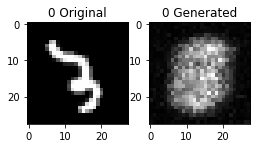

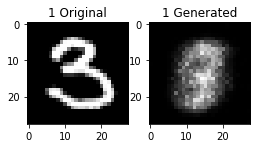

Epoch: 0200 cost = 422.114837646


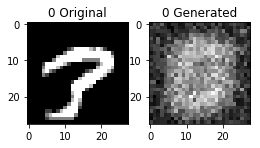

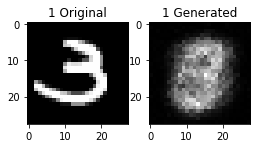

Epoch: 0300 cost = 406.220214844


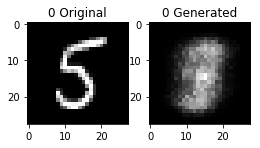

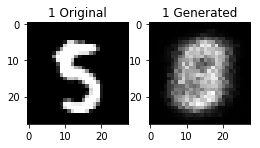

Epoch: 0400 cost = 401.290710449


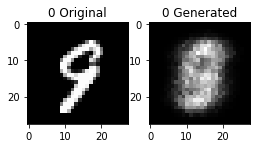

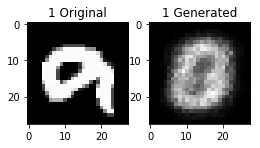

Epoch: 0500 cost = 396.268585205


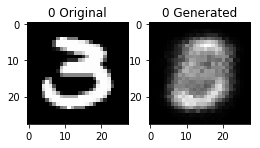

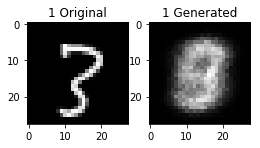

Epoch: 0600 cost = 390.133789062


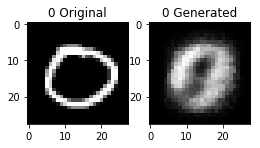

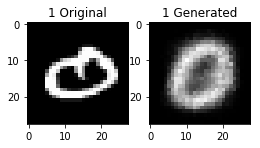

Epoch: 0700 cost = 386.427886963


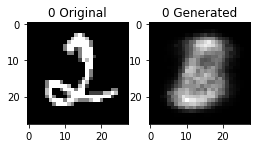

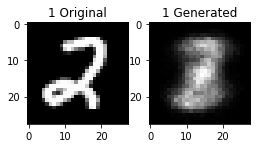

Epoch: 0800 cost = 382.236633301


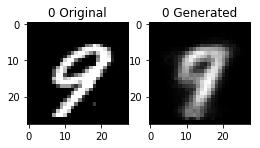

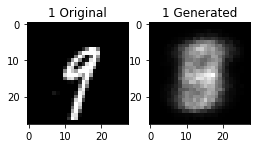

Epoch: 0900 cost = 377.839599609


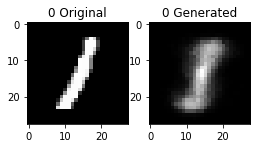

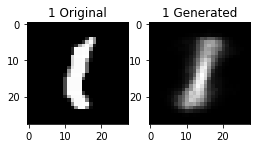

Epoch: 1000 cost = 373.315460205


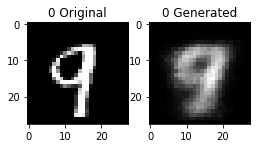

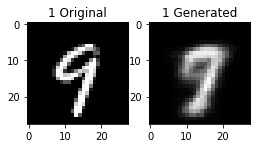

In [12]:
# Write logs to Tensorboard
#summary_writer = tf.summary.FileWriter("logs_path", graph=tf.get_default_graph())
            
cost_log = []
# Start Training
for epoch in range(TRAINING_EPOCHS):
    # Run optimization op (backprop), cost op (to get loss value)
    _, c = sess.run([train_op, cost], feed_dict=feed_dict_train)

    cost_log.append(c)
    
    # Print generated data after every 100 epoch
    if (epoch + 1) % 100 == 0:
        example = np.random.randint(num_of_examples, size=1)
        print("Epoch:", '%04d' % (epoch+1), "cost =", "{:.9f}".format(c))
        
        for a_domain in range(num_of_domains):
            #print("a_domain: ", a_domain)
            fig, all_plots = plt.subplots(1, 2, figsize=(4, 4))
            generated_output = sess.run(placeholder["prediction"], feed_dict=feed_dict_train)

            canvas_orig = domains_data_train['domain_'+str(a_domain)][example].reshape([28, 28])
            all_plots[0].set_title(str(a_domain)+" Original")
            all_plots[0].imshow(canvas_orig, origin="upper", cmap="gray")

            canvas_recon = generated_output[a_domain][example].reshape([28, 28])
            all_plots[1].set_title(str(a_domain)+" Generated")
            all_plots[1].imshow(canvas_recon, origin="upper", cmap="gray")
        
        plt.show()

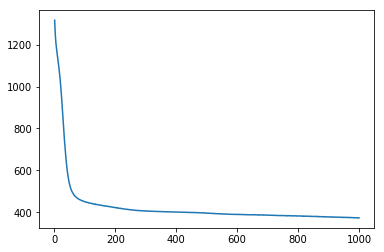

In [13]:
plt.plot(range(1, len(cost_log)+1), cost_log)
plt.show()

In [14]:
test_labels_names_dict = get_labels_names_dict(test_labels_names, num_of_examples)
domains_data_test, domains_label_test = get_domains_data(test_data, num_of_domains, test_labels_names_dict)
feed_dict_test = get_feed_dict(domains_data_test, num_of_domains)

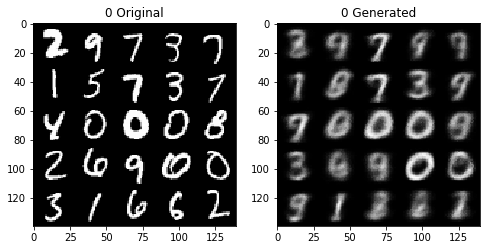

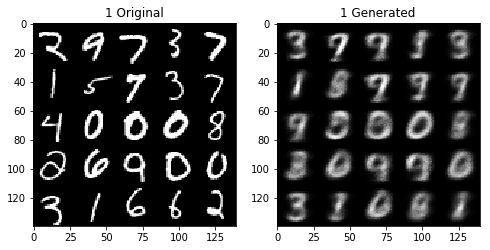

In [15]:
# Testing
# Encode and decode images from test set and visualize their reconstruction.
n = 5
examples = np.random.randint(num_of_examples, size=n*n)

for a_domain in range(num_of_domains):
    canvas_orig = np.empty((28 * n, 28 * n))
    canvas_recon = np.empty((28 * n, 28 * n))
    fig, all_plots = plt.subplots(1, 2, figsize=(8, 8))
    for i in range(n):
        # MNIST test set
        # Encode and decode the digit image
        g = sess.run(placeholder["prediction"][a_domain], feed_dict=feed_dict_test)
        
        # Display original images
        for j, example_i in zip(range(n), examples[i*n:i*n+n]):
            # Draw the generated digits
            canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = domains_data_test['domain_'+str(a_domain)][example_i].reshape([28, 28])
        # Display reconstructed images
        for j, example_i in zip(range(n), examples[i*n:i*n+n]):
            # Draw the generated digits
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[example_i].reshape([28, 28])

    all_plots[0].set_title(str(a_domain)+" Original")
    all_plots[0].imshow(canvas_orig, origin="upper", cmap="gray")

    all_plots[1].set_title(str(a_domain)+" Generated")
    all_plots[1].imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()

In [16]:
g = sess.run(code_prediction, feed_dict=feed_dict_test)
print(g.shape)

(5000, 512)


In [17]:
from sklearn.decomposition import PCA

g_embedded = PCA(n_components=2).fit_transform(g)

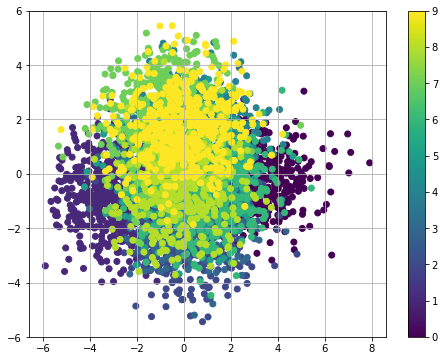

In [18]:
plt.figure(figsize=(8, 6)) 
plt.scatter(g_embedded[:, 0], g_embedded[:, 1], c=domains_label_test['domain_0'])
plt.colorbar()
plt.grid()